In [ ]:
import pandas as pd
import torch
from PIL import Image
from transformers import (
    Blip2Processor, Blip2ForConditionalGeneration,
    VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
)
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Для работы выбраны две LLM:

1. Blip-2 (эта модель пооедрживает промты, но для более честного сравнения обе модели будут выдавать только описание фотографии)

2. Vit-GPT2 (Так как эта модель может только описывать картинку, то мы будем парсить ее ответ и выявлять, она описала военную или граждансую машину, для этого создадим список с ключевыми словами по военным и гражданским машинам)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Ключевые слова для классификации ViT-GPT2
military_keywords = [
    'military', 'army', 'camouflage', 'tactical', 'hummer',
    'armored', 'soldier', 'combat', 'defense', 'weapon',
    'camouflaged', 'uniform', 'barracks', 'patrol',
    'war', 'battle', 'troop', 'commando', 'special forces'
]

civilian_keywords = [
    'civilian', 'suv', 'car', 'vehicle', 'city', 'urban',
    'family', 'street', 'road', 'passenger',
    'red', 'blue', 'silver', 'modern', 'shiny', 'chrome',
    'luxury', 'comfort', 'sedan', 'hatchback', 'minivan'
]


Функции для иницирования LLM моделей

In [13]:
def load_blip2_model():
    """Загрузка BLIP-2 модели"""
    blip2_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-6.7b")
    blip2_model = Blip2ForConditionalGeneration.from_pretrained(
        "Salesforce/blip2-opt-2.7b",
        torch_dtype=torch.float16,
        device_map="auto"
    )
    print("BLIP-2 модель загружена")
    return blip2_processor, blip2_model

def load_vit_gpt2_model():
    """Загрузка ViT-GPT2 модели"""
    vit_gpt2_model = VisionEncoderDecoderModel.from_pretrained(
        "nlpconnect/vit-gpt2-image-captioning"
    )
    vit_gpt2_feature_extractor = ViTImageProcessor.from_pretrained(
        "nlpconnect/vit-gpt2-image-captioning"
    )
    vit_gpt2_tokenizer = AutoTokenizer.from_pretrained(
        "nlpconnect/vit-gpt2-image-captioning"
    )
    vit_gpt2_model.to(device)
    print("ViT-GPT2 модель загружена")
    return vit_gpt2_model, vit_gpt2_feature_extractor, vit_gpt2_tokenizer

Функции для определения к какому классу модель классифицировала изображение:

1. Blip-2

2. Vit-GPT2

Ответ будет исходить из парсинга данных, будут суммироваться ключевые слова, в случае равного количества - предпочтение будет отдаваться военным машинам, в случае нулевого результата - ответом будет являться гражданская машина

In [14]:
def classify_from_description(description):
    """Классификация на основе сгенерированного описания"""
    military_count = sum(1 for word in military_keywords if word in description.lower())
    civilian_count = sum(1 for word in civilian_keywords if word in description.lower())

    # Логика принятия решения
    if military_count > civilian_count:
        return 'military'
    elif civilian_count > military_count:
        return 'civilian'
    elif military_count == civilian_count:
        if military_count == 0:  # если оба нуля
            return 'civilian'
        else:  # если равны и не нули
            return 'military'

Функции для вызова моделей и получения ответа

Все ответы записываются в csv файл, исходя из того, что у моделей есть ограничения на вызовы. В случае того, если будем что-то править, необходимо не вызывать модели повторно, а просто открыть файлы с полученными ранее ответами

In [16]:
def classify_blip2_single(image_path, blip2_processor, blip2_model):
    """Классификация одного изображения с помощью BLIP-2"""
    try:
        image = Image.open(image_path).convert('RGB')


        inputs = blip2_processor(
            images=image,
            #text=prompt,
            return_tensors="pt"
        ).to(device, torch.float16)

        generated_ids = blip2_model.generate(
            **inputs,
            max_new_tokens=20,
            num_beams=5,
            early_stopping=True
        )
        generated_text = blip2_processor.batch_decode(
            generated_ids, skip_special_tokens=True
        )[0].strip()

        print(generated_text)
        return classify_from_description(generated_text)

    except Exception as e:
        print(f"Ошибка обработки {image_path} с BLIP-2: {e}")
        return "error"

def classify_vit_gpt2_single(image_path, vit_gpt2_model, vit_gpt2_feature_extractor, vit_gpt2_tokenizer):
    """Классификация одного изображения с помощью ViT-GPT2"""
    try:
        image = Image.open(image_path).convert('RGB')

        # Генерируем описание изображения
        pixel_values = vit_gpt2_feature_extractor(
            images=image, return_tensors="pt"
        ).pixel_values.to(device)

        generated_ids = vit_gpt2_model.generate(
            pixel_values,
            max_length=100,
            num_beams=4,
            early_stopping=True
        )
        generated_text = vit_gpt2_tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True
        )[0].strip()
        print(generated_text)

        return classify_from_description(generated_text)

    except Exception as e:
        print(f"Ошибка обработки {image_path} с ViT-GPT2: {e}")
        return "civilian"


def get_blip2_predictions(image_folder, output_file='blip_predictions.csv'):
    """Получение ответов BLIP-2 и сохранение в CSV"""

    # Загрузка модели
    blip2_processor, blip2_model = load_blip2_model()

    # Получение списка изображений
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg'))]
    image_files.sort(key=lambda x: int(os.path.splitext(x)[0]))

    print(f"Blip-2. Найдено {len(image_files)} изображений")

    results = []

    for image_file in image_files:
        photo_num = os.path.splitext(image_file)[0]
        image_path = os.path.join(image_folder, image_file)

        # Классификация BLIP-2
        prediction = classify_blip2_single(image_path, blip2_processor, blip2_model)

        results.append({
            'номер фото': photo_num,
            'ответ модели': prediction
        })


        print(f"Обработано фото {image_path}: {prediction}")

    # Сохранение в CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    print(f"Предсказания BLIP-2 сохранены в {output_file}")

    return results_df

def get_vit_gpt2_predictions(image_folder, output_file='gpt_predictions.csv'):
    """Получение предсказаний ViT-GPT2 и сохранение в CSV"""

    # Загрузка модели
    vit_gpt2_model, vit_gpt2_feature_extractor, vit_gpt2_tokenizer = load_vit_gpt2_model()

    # Получение списка изображений
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg'))]
    image_files.sort(key=lambda x: int(os.path.splitext(x)[0]))

    print(f"Vit-GPT2. Найдено {len(image_files)} изображений")

    results = []

    for image_file in image_files:
        photo_num = os.path.splitext(image_file)[0]
        image_path = os.path.join(image_folder, image_file)

        # Классификация ViT-GPT2
        prediction = classify_vit_gpt2_single(image_path, vit_gpt2_model, vit_gpt2_feature_extractor, vit_gpt2_tokenizer)

        results.append({
            'номер фото': photo_num,
            'ответ модели': prediction
        })


        print(f"Обработано фото {image_path}: {prediction}")

    # Сохранение в CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    print(f"Предсказания ViT-GPT2 сохранены в {output_file}")

    return results_df



In [18]:
image_folder = "image"
blip_results = get_blip2_predictions(image_folder)
print("Первые 5 предсказаний BLIP-2:")
print(blip_results.head())


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

BLIP-2 модель загружена
Blip-2. Найдено 30 изображений
the 2021 kia sportage is driving down a city street
Обработано фото image/1.jpg: civilian
the opel is parked on the beach at sunset
Обработано фото image/2.jpg: civilian
2019 bmw m5 competition
Обработано фото image/3.jpg: civilian
a black car is parked in front of a garage
Обработано фото image/4.jpg: civilian
the blue ford focus is driving on the road
Обработано фото image/5.jpg: civilian
a silver ford fiesta is driving down the road
Обработано фото image/6.jpg: civilian
the new renault suv is driving down a dirt road
Обработано фото image/7.jpg: civilian
the white nissan qashqai is parked on the side of the road
Обработано фото image/8.jpg: civilian
a red car is driving down a city street
Обработано фото image/9.jpg: civilian
the 2020 honda accord is driving down the road
Обработано фото image/10.jpg: civilian
an army green jeep driving down the street
Обработано фото image/11.jpg: military
a military vehicle is parked in a park

In [7]:
vit_gpt2_results = get_vit_gpt2_predictions(image_folder)
print("Первые 5 предсказаний ViT-GPT2:")
print(vit_gpt2_results.head())

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


ViT-GPT2 модель загружена
Vit-GPT2. Найдено 30 изображений


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


a blue car is driving down the street
Обработано фото image/1.jpg: civilian
a small yellow car is parked on the beach
Обработано фото image/2.jpg: civilian
a blue car is parked in a parking lot
Обработано фото image/3.jpg: civilian
a black car parked next to a white car
Обработано фото image/4.jpg: civilian
a car that is driving down the road
Обработано фото image/5.jpg: civilian
a small white car parked in a parking lot
Обработано фото image/6.jpg: civilian
a blue pick up truck parked in a parking lot
Обработано фото image/7.jpg: civilian
a white car parked in front of a building
Обработано фото image/8.jpg: civilian
a red car parked on the side of a road
Обработано фото image/9.jpg: civilian
a car parked on the side of a road
Обработано фото image/10.jpg: civilian
an old truck is parked on the side of the road
Обработано фото image/11.jpg: civilian
a military vehicle is parked in a parking lot
Обработано фото image/12.jpg: military
a truck parked in a grassy field with people standin

Загрузка данных из CSV файла, а также данные для проверки результата

In [52]:
def load_true_labels(file):
    """Загрузка истинных меток"""
    df = pd.read_csv(file)
    # Преобразуем в словарь {номер_фото: метка}
    labels_dict = {}
    for _, row in df.iterrows():
        photo_num = str(row['Номер фото']).split('.')[0]
        label = row['Наименование машины'].lower()
        labels_dict[photo_num] = label
    return labels_dict

def load_all_data(true_labels_file, blip_file, gpt_file):
    """Загрузка всех данных для оценки"""
    # Истинные метки
    true_labels = load_true_labels(true_labels_file)

    # Предсказания моделей
    blip_preds = pd.read_csv(blip_file)
    gpt_preds = pd.read_csv(gpt_file)

    # Объединение данных
    results = []
    for photo_num, true_label in true_labels.items():
        blip_row = blip_preds[blip_preds['номер фото'] == int(photo_num)]
        gpt_row = gpt_preds[gpt_preds['номер фото'] == int(photo_num)]

        if not blip_row.empty and not gpt_row.empty:
            results.append({
                'photo_number': photo_num,
                'true_label': true_label,
                'blip2_pred': blip_row['ответ модели'].iloc[0],
                'vit_gpt2_pred': gpt_row['ответ модели'].iloc[0]
            })
    print(results)
    return pd.DataFrame(results)

# Загрузка данных
true_labels_file = "dataset.csv"
blip_file = "blip_predictions.csv"
gpt_file = "gpt_predictions.csv"

evaluation_data = load_all_data(true_labels_file, blip_file, gpt_file)
print(f"Загружено {len(evaluation_data)} записей для оценки")
print("Первые 5 строк данных для оценки:")
print(evaluation_data.head())

[{'photo_number': '1', 'true_label': 'civilian', 'blip2_pred': 'civilian', 'vit_gpt2_pred': 'civilian'}, {'photo_number': '2', 'true_label': 'civilian', 'blip2_pred': 'civilian', 'vit_gpt2_pred': 'civilian'}, {'photo_number': '3', 'true_label': 'civilian', 'blip2_pred': 'civilian', 'vit_gpt2_pred': 'civilian'}, {'photo_number': '4', 'true_label': 'civilian', 'blip2_pred': 'civilian', 'vit_gpt2_pred': 'civilian'}, {'photo_number': '5', 'true_label': 'civilian', 'blip2_pred': 'civilian', 'vit_gpt2_pred': 'civilian'}, {'photo_number': '6', 'true_label': 'civilian', 'blip2_pred': 'civilian', 'vit_gpt2_pred': 'civilian'}, {'photo_number': '7', 'true_label': 'civilian', 'blip2_pred': 'civilian', 'vit_gpt2_pred': 'civilian'}, {'photo_number': '8', 'true_label': 'civilian', 'blip2_pred': 'civilian', 'vit_gpt2_pred': 'civilian'}, {'photo_number': '9', 'true_label': 'civilian', 'blip2_pred': 'civilian', 'vit_gpt2_pred': 'civilian'}, {'photo_number': '10', 'true_label': 'civilian', 'blip2_pred': 

Расчет метрик и построение матрицы ошибок (confusion matrix)

In [60]:
def calculate_metrics_for_model(true_labels, predictions, model_name):
    """Расчет метрик"""
    # Преобразуем в бинарный формат для метрик (1 - military, 0 - civilian)
    true_binary = [1 if label == 'military' else 0 for label in true_labels]
    pred_binary = [1 if label == 'military' else 0 for label in predictions]

    accuracy = accuracy_score(true_binary, pred_binary)
    precision = precision_score(true_binary, pred_binary, zero_division=0)
    recall = recall_score(true_binary, pred_binary, zero_division=0)
    cm = confusion_matrix(true_binary, pred_binary)

    print(f"\n{model_name} Метрики:")
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")

    return accuracy, precision, recall, cm

def plot_confusion_matrices(blip2_cm, vit_gpt2_cm):
    """Построение матриц ошибок="""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    sns.heatmap(blip2_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Civilian', 'Military'],
                yticklabels=['Civilian', 'Military'], ax=ax1)
    ax1.set_title('BLIP-2 Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted', fontsize=12)
    ax1.set_ylabel('Actual', fontsize=12)

    sns.heatmap(vit_gpt2_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Civilian', 'Military'],
                yticklabels=['Civilian', 'Military'], ax=ax2)
    ax2.set_title('ViT-GPT2 Confusion Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted', fontsize=12)
    ax2.set_ylabel('Actual', fontsize=12)

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()


Вывод результатов

------------------------------------------------------------
Результаты сравнения
------------------------------------------------------------

BLIP-2 Метрики:
Accuracy:  0.700
Precision: 0.545
Recall:    0.600

ViT-GPT2 Метрики:
Accuracy:  0.800
Precision: 0.700
Recall:    0.700


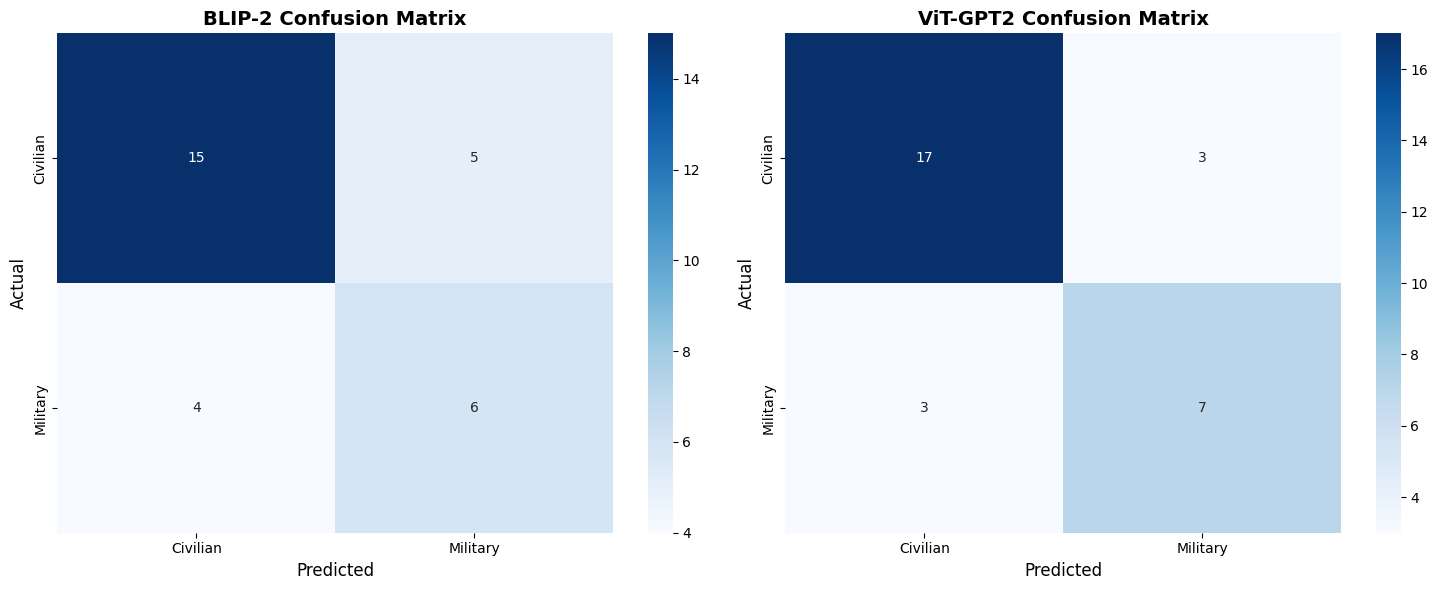

In [61]:
def evaluate_all_models(evaluation_df):
    """Оценка всех моделей"""
    true_labels = evaluation_df['true_label']
    blip2_preds = evaluation_df['blip2_pred']
    vit_gpt2_preds = evaluation_df['vit_gpt2_pred']

    print("-"*60)
    print("Результаты сравнения")
    print("-"*60)

    # Расчет метрик для BLIP-2
    blip2_accuracy, blip2_precision, blip2_recall, blip2_cm = calculate_metrics_for_model(
        true_labels, blip2_preds, "BLIP-2"
    )

    # Расчет метрик для ViT-GPT2
    vit_gpt2_accuracy, vit_gpt2_precision, vit_gpt2_recall, vit_gpt2_cm = calculate_metrics_for_model(
        true_labels, vit_gpt2_preds, "ViT-GPT2"
    )

    # Построение матриц ошибок
    plot_confusion_matrices(blip2_cm, vit_gpt2_cm)

    return {
        'blip2': {
            'accuracy': blip2_accuracy,
            'precision': blip2_precision,
            'recall': blip2_recall,
            'confusion_matrix': blip2_cm
        },
        'vit_gpt2': {
            'accuracy': vit_gpt2_accuracy,
            'precision': vit_gpt2_precision,
            'recall': vit_gpt2_recall,
            'confusion_matrix': vit_gpt2_cm
        }
    }

# Запуск оценки
metrics = evaluate_all_models(evaluation_data)

Детальный анализ ошибок. Анализ ответа на каждом изображении, так как датасет построен так: тривиальные военные машины, тривиальные гражданские машины, нетривиальные случаи.

Метрики, конечно, хорошо, но хотелось бы понять, где именно моедли ошибались, в каких случаях

In [66]:
def analyze_errors(evaluation_df):
    """Детальный анализ ошибок"""

    blip2_errors = evaluation_df[evaluation_df['true_label'] != evaluation_df['blip2_pred']]
    vit_gpt2_errors = evaluation_df[evaluation_df['true_label'] != evaluation_df['vit_gpt2_pred']]

    print("-"*50)
    print("Детальный анализ")
    print("-"*50)

    print(f"\nBLIP-2 совершил {len(blip2_errors)} ошибок:")
    for _, error in blip2_errors.iterrows():
        print(f"  Фото {error['photo_number']}: Истинный={error['true_label']}, Предсказанный={error['blip2_pred']}")

    print(f"\nViT-GPT2 совершил {len(vit_gpt2_errors)} ошибок:")
    for _, error in vit_gpt2_errors.iterrows():
        print(f"  Фото {error['photo_number']}: Истинный={error['true_label']}, Предсказанный={error['vit_gpt2_pred']}")

    # Общие ошибки
    common_errors = evaluation_df[
        (evaluation_df['true_label'] != evaluation_df['blip2_pred']) &
        (evaluation_df['true_label'] != evaluation_df['vit_gpt2_pred'])
    ]

    print(f"\nОбе модели ошиблись на {len(common_errors)} фотографиях:")
    for _, error in common_errors.iterrows():
        print(f"  Фото {error['photo_number']}: Истинный={error['true_label']}")

    return blip2_errors, vit_gpt2_errors, common_errors

blip2_errors, vit_gpt2_errors, common_errors = analyze_errors(evaluation_data)

--------------------------------------------------
Детальный анализ
--------------------------------------------------

BLIP-2 совершил 9 ошибок:
  Фото 13: Истинный=military, Предсказанный=civilian
  Фото 18: Истинный=military, Предсказанный=civilian
  Фото 19: Истинный=military, Предсказанный=civilian
  Фото 20: Истинный=military, Предсказанный=civilian
  Фото 22: Истинный=civilian, Предсказанный=military
  Фото 23: Истинный=civilian, Предсказанный=military
  Фото 24: Истинный=civilian, Предсказанный=military
  Фото 26: Истинный=civilian, Предсказанный=military
  Фото 29: Истинный=civilian, Предсказанный=military

ViT-GPT2 совершил 6 ошибок:
  Фото 11: Истинный=military, Предсказанный=civilian
  Фото 13: Истинный=military, Предсказанный=civilian
  Фото 18: Истинный=military, Предсказанный=civilian
  Фото 23: Истинный=civilian, Предсказанный=military
  Фото 24: Истинный=civilian, Предсказанный=military
  Фото 25: Истинный=civilian, Предсказанный=military

Обе модели ошиблись на 4 фото

Вывод и результаты, сходя из детального анализа

In [67]:
def create_summary_report(metrics, evaluation_data, blip2_errors, vit_gpt2_errors, common_errors):

    print("-"*60)
    print("Сравнение моделей, исходя из детального результата и результата по метрикам")
    print("-"*60)

    print(f"\nОбщая статистика:")
    print(f"Всего изображений: {len(evaluation_data)}")
    print(f"Гражданских в датасете: {len(evaluation_data[evaluation_data['true_label'] == 'civilian'])}")
    print(f"Военных в датасете: {len(evaluation_data[evaluation_data['true_label'] == 'military'])}")

    print(f"\nСравнение моделей:")
    print(f"BLIP-2 Accuracy: {metrics['blip2']['accuracy']:.3f}")
    print(f"ViT-GPT2 Accuracy: {metrics['vit_gpt2']['accuracy']:.3f}")

    if metrics['blip2']['accuracy'] > metrics['vit_gpt2']['accuracy']:
        winner = "BLIP-2"
        advantage = metrics['blip2']['accuracy'] - metrics['vit_gpt2']['accuracy']
    else:
        winner = "ViT-GPT2"
        advantage = metrics['vit_gpt2']['accuracy'] - metrics['blip2']['accuracy']

    print(f"\nЛучшая модель: {winner} (преимущество: {advantage:.3f})")
    print(f"Общие ошибки обеих моделей: {len(common_errors)} изображений")

create_summary_report(metrics, evaluation_data, blip2_errors, vit_gpt2_errors, common_errors)

------------------------------------------------------------
Сравнение моделей, исходя из детального результата и результата по метрикам
------------------------------------------------------------

Общая статистика:
Всего изображений: 30
Гражданских в датасете: 20
Военных в датасете: 10

Сравнение моделей:
BLIP-2 Accuracy: 0.700
ViT-GPT2 Accuracy: 0.800

Лучшая модель: ViT-GPT2 (преимущество: 0.100)
Общие ошибки обеих моделей: 4 изображений


Фотографии, где ошиблись обе модели

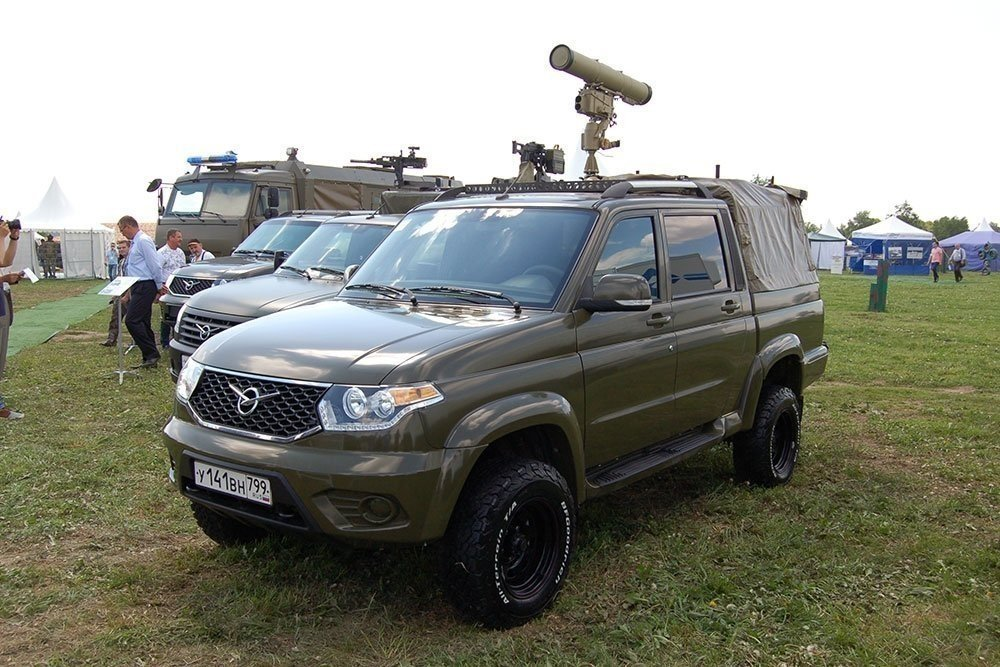

In [75]:
'''
Фото 13: Истинный=military
Фото 18: Истинный=military
Фото 23: Истинный=civilian
Фото 24: Истинный=civilian
'''
from IPython.display import Image
Image(filename='image/13.jpg')


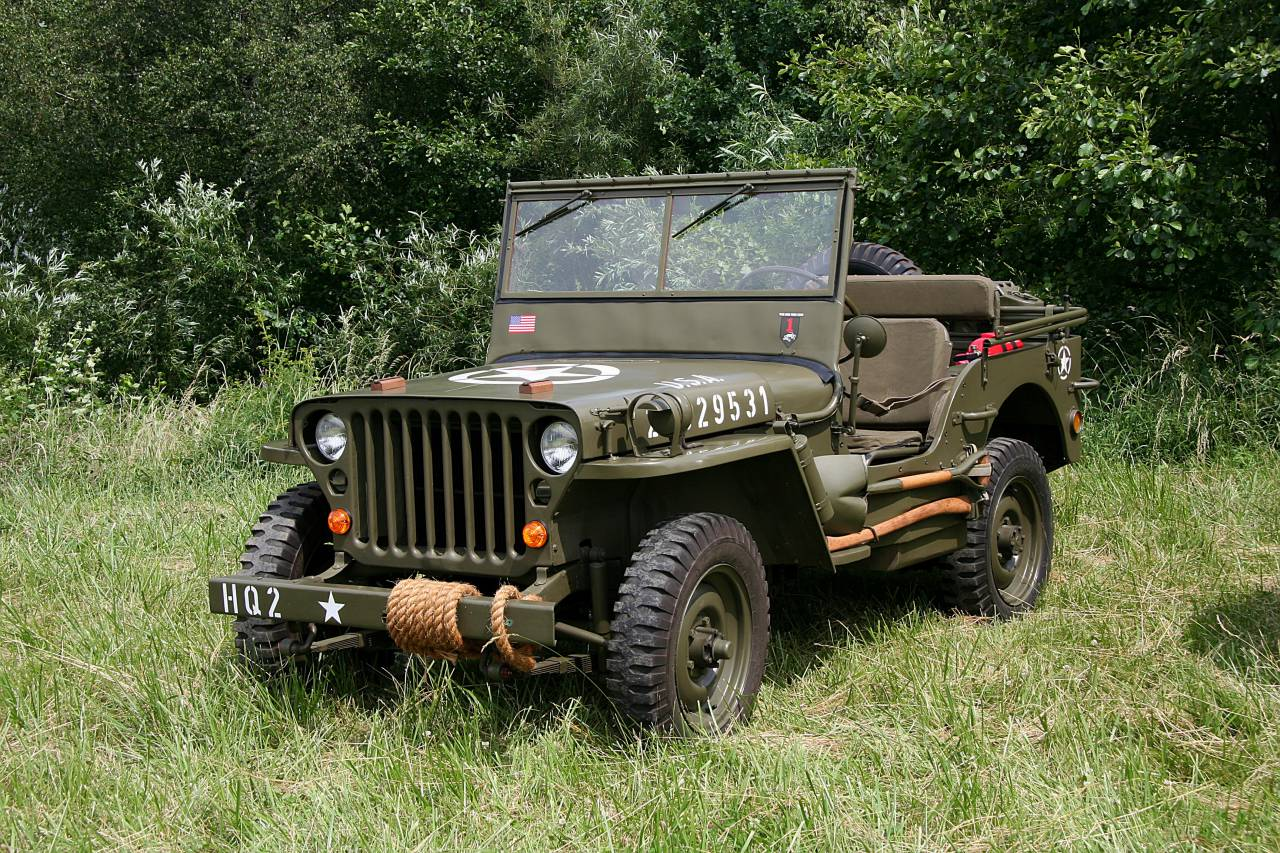

In [76]:
Image(filename='image/18.jpg')

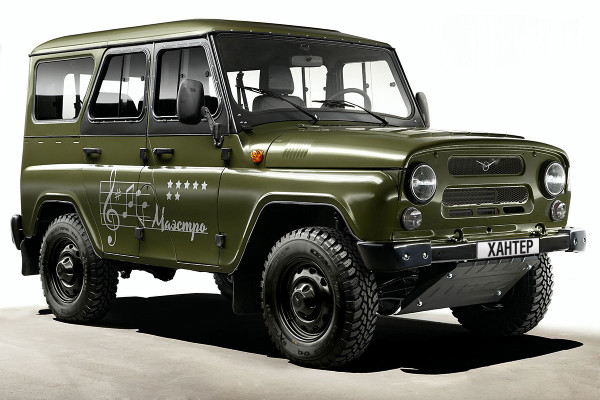

In [77]:
Image(filename='image/23.jpg')

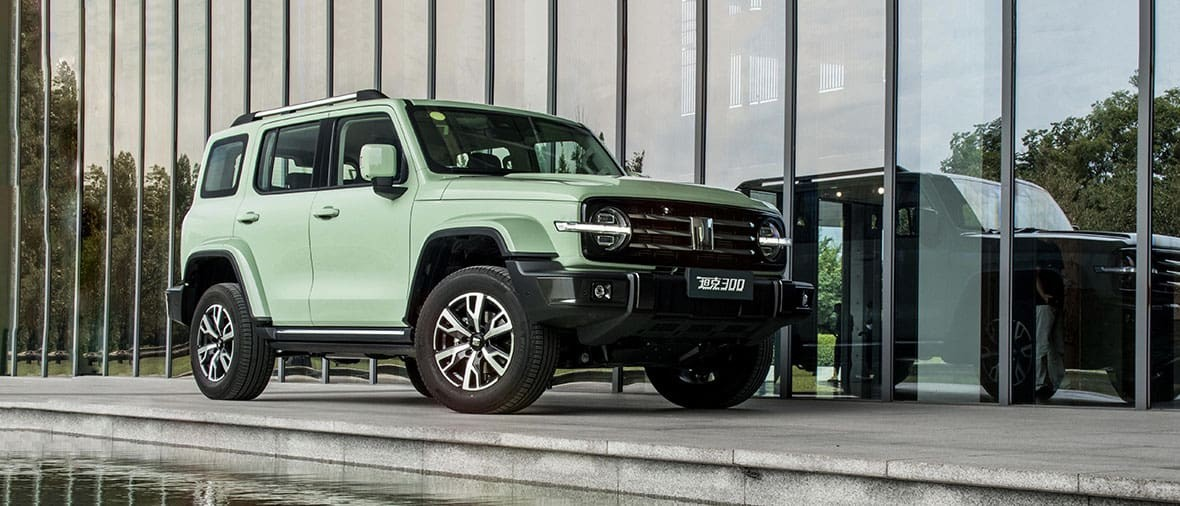

In [78]:
Image(filename='image/24.jpg')